# Workshop 8. Наивный Байес и Классификация текстов

> Байесовские алгоритмы для классификации текстов  
> Извлечение признаков из текста

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [Naive Bayes and Text Classification](https://sebastianraschka.com/Articles/2014_naive_bayes_1.html)
- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Байесовский классификатор](http://www.machinelearning.ru/wiki/index.php?title=%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80)
- [Интересная статья про спам/не спам](https://habrahabr.ru/post/252265/)

Если вам понравилась задача распознавания текстов, то вот подборочка:

- [библиотека Gensim](https://radimrehurek.com/gensim/)
- [библиотека nltk](http://www.nltk.org/)
- [Лекция про word2vec 🔥](https://www.youtube.com/watch?v=oBb9aFmp0Hs)
- [Лекция Векторные представления слов и документов 🔥](https://www.youtube.com/watch?v=hiDBnEyoZS4)

## Наивный байесовский классификатор

На практике мы использовали его для детекции спам/не спам. В этот раз вы будете классифицировать [новостные тексты](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html). Попробуете разные методы  генерации признаков из текстов.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import scale

In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### 2.1 Загрузка данных (2 балла)

Мы будем использовать только 4 класса текстов: `'alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics'`.

Загрузите тренировочную и тестовую части датасета для этих категорий.

In [3]:
categories = ['alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)
train_data, train_labels = newsgroups_train.data, newsgroups_train.target
test_data, test_labels = newsgroups_test.data, newsgroups_test.target

In [4]:
len(newsgroups_train.target)

2034

In [5]:
for i in newsgroups_train:
  print(i)

data
filenames
target_names
target
DESCR


Выведите по 1 тексту для каждой из категории.

In [6]:
for cat in categories:
    print(cat, fetch_20newsgroups(subset='train', categories=[cat]).data[:1], '\n')

alt.atheism ['From: darice@yoyo.cc.monash.edu.au (Fred Rice)\nSubject: Re: Islam & Dress Code for women\nOrganization: Monash University, Melb., Australia.\nLines: 120\n\nIn <16BA7103C3.I3150101@dbstu1.rz.tu-bs.de> I3150101@dbstu1.rz.tu-bs.de (Benedikt Rosenau) writes:\n\n>In article <1993Apr5.091258.11830@monu6.cc.monash.edu.au>\n>darice@yoyo.cc.monash.edu.au (Fred Rice) writes:\n> \n>(Deletion)\n>>>>Of course people say what they think to be the religion, and that this\n>>>>is not exactly the same coming from different people within the\n>>>>religion.  There is nothing with there existing different perspectives\n>>>>within the religion -- perhaps one can say that they tend to converge on\n>>>>the truth.\n>>\n>>>My point is that they are doing a lot of harm on the way in the meantime.\n>>>\n>>>And that they converge is counterfactual, religions appear to split and\n>>>diverge. Even when there might be a \'True Religion\' at the core, the layers\n>>>above determine what happens in prac

### 2.2 Мешок слов

Начнем с самого простого способа извлечения признаков из текстов: обычный подсчет количества употреблений слов в тексте.

Для этого используем [sklearn.feature_extraction.text.CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Настройте его так, чтобы он использовал англиские стоп слова.

Проведите трансформаци текстов из обоих датасетов и выведите размер полученного словаря. (1 векторайзер для тестового и тренировочного датасета! У вас должны получиться матрицы с одинаковыми признаками-словами)

In [7]:
all_data = list()
all_data.extend(train_data)
all_data.extend(test_data)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(stop_words='english')
count_vect.fit(all_data)
X_train_counts = count_vect.transform(train_data)
X_test_counts = count_vect.transform(test_data)

In [9]:
X_train_counts.shape

(2034, 43255)

In [10]:
count_vect.vocabulary_.get(u'algorithm')

6735

In [11]:
X_test_counts.shape

(1353, 43255)

Будем использовать классифиактор для мультиклассифкации [sklearn.naive_bayes.MultinomialNB]().

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

In [13]:
clf = MultinomialNB()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_train_counts, train_labels, scoring='accuracy', cv=cv, n_jobs = -1)
print('mean = ', scores.mean(), ' std = ', np.std(scores))

mean =  0.959683373476477  std =  0.005531633627262167


In [14]:
clf.fit(X_train_counts, train_labels)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [15]:
%time y_pred = clf.predict(X_test_counts)
y_test = newsgroups_test.target

CPU times: user 4.09 ms, sys: 270 µs, total: 4.36 ms
Wall time: 6.16 ms


[Text(0, 0.5, 'alt.atheism'),
 Text(0, 1.5, 'sci.space'),
 Text(0, 2.5, 'talk.religion.misc'),
 Text(0, 3.5, 'comp.graphics')]

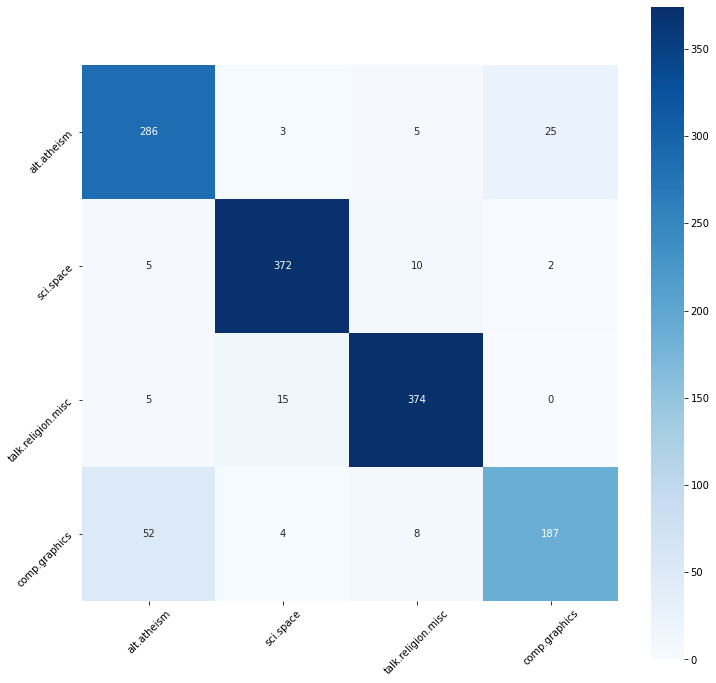

In [16]:
plt.figure(figsize=(12,12)) 

heatmap = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g')
heatmap.set_xticklabels(categories, rotation=45)
heatmap.set_yticklabels(categories, rotation=45)

In [17]:
print(classification_report(y_test, y_pred)) # Тестовая выборка

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       319
           1       0.94      0.96      0.95       389
           2       0.94      0.95      0.95       394
           3       0.87      0.75      0.80       251

    accuracy                           0.90      1353
   macro avg       0.90      0.89      0.89      1353
weighted avg       0.90      0.90      0.90      1353



In [18]:
print(classification_report(train_labels, clf.predict(X_train_counts))) # Обучающая выборка

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       480
           1       1.00      1.00      1.00       584
           2       1.00      1.00      1.00       593
           3       0.99      0.95      0.97       377

    accuracy                           0.99      2034
   macro avg       0.99      0.99      0.99      2034
weighted avg       0.99      0.99      0.99      2034



In [19]:
# Посмотрим на ТОП 10 по важности слова в каждой категории

def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("%s: [%s]" % (category, " ".join(feature_names[top10])))

show_top10(clf, count_vect, newsgroups_train.target_names)

alt.atheism: [article organization don lines subject com writes people god edu]
comp.graphics: [file posting university com image organization graphics subject lines edu]
sci.space: [gov article writes com lines organization subject nasa edu space]
talk.religion.misc: [article writes lines jesus organization people subject god com edu]


### 2.3 [Tf-IDF](https://ru.wikipedia.org/wiki/TF-IDF)

Мешок слов не учитывает "веса" слов, он просто смотрит их вхождение в документ. Вероятно, было бы полезно взвесить каким-то обраом каждое слово в документе. Действительно, если слово встречается во всех документах, то, наверное, его вес небольшой. А если редкое слово встречается в некоторых документах, то скорее всего оно какое-то узко тематическое.

Один из способов взвесить слова - это использовать меру tf-idf, где:

**TF - term frequency** - частота слова для каждой статьи

$$\LARGE \mathrm{tf}(t,d) = \frac{n_t}{\sum_k n_k}$$

**IDF - inverse document frequency*** — обратная частота документа - уменьшает вес часто встречаемых слов

$$\LARGE \mathrm{idf}(t, D) =  \log \frac{|D|}{|\{\,d_i \in D \mid t \in d_{i}\, \}|}$$

$D$ - число документов в корпусе

$|\{\,d_i \in D \mid t \in d_{i}\, \}|$ - число документов из коллекции ${\displaystyle D}$ , в которых встречается ${\displaystyle t}$  (когда ${\displaystyle n_{t}\neq 0}$ ).

**TF-IDF**

$$\LARGE \operatorname{tf-idf}(t,d,D) = \operatorname{tf}(t,d) \times \operatorname{idf}(t, D)$$


Для него есть класс [sklearn.feature_extraction.text.TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

vectorizer.fit(all_data)

X_train_tfidf = vectorizer.transform(train_data)
X_test_tfidf = vectorizer.transform(test_data)

In [21]:
X_train_tfidf.shape

(2034, 43562)

In [22]:
X_test_tfidf.shape

(1353, 43562)

In [23]:
clfNB = MultinomialNB()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clfNB, X_train_tfidf, train_labels, scoring='accuracy', cv=cv, n_jobs = -1)
print('mean = ', scores.mean(), ' std = ', np.std(scores))

mean =  0.8800329214122318  std =  0.007304978913407815


In [24]:
clfNB.fit(X_train_tfidf, train_labels)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [25]:
%time y_pred = clfNB.predict(X_test_tfidf)
y_test = newsgroups_test.target

CPU times: user 4.62 ms, sys: 0 ns, total: 4.62 ms
Wall time: 5 ms


[Text(0, 0.5, 'alt.atheism'),
 Text(0, 1.5, 'sci.space'),
 Text(0, 2.5, 'talk.religion.misc'),
 Text(0, 3.5, 'comp.graphics')]

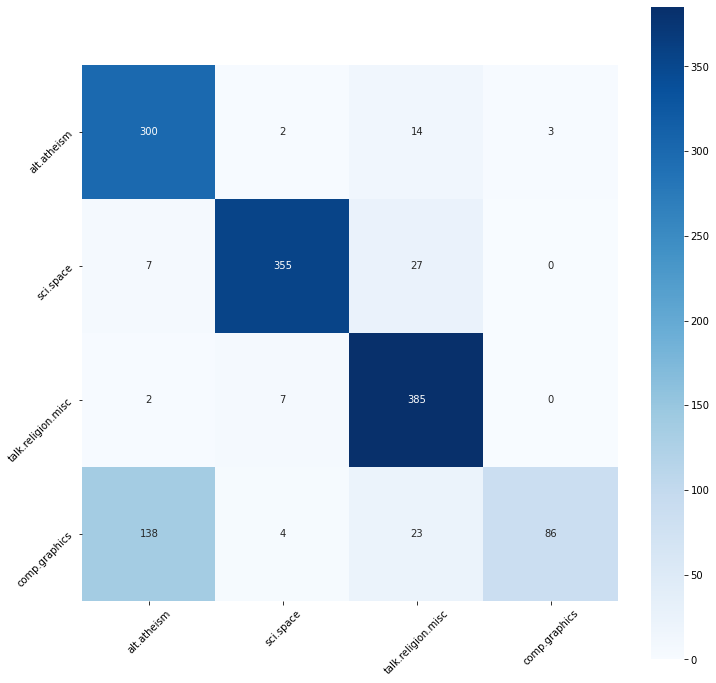

In [26]:
plt.figure(figsize=(12,12)) 

heatmap = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g')
heatmap.set_xticklabels(categories, rotation=45)
heatmap.set_yticklabels(categories, rotation=45)

In [27]:
print(classification_report(y_test, y_pred)) # Тестовая выборка

              precision    recall  f1-score   support

           0       0.67      0.94      0.78       319
           1       0.96      0.91      0.94       389
           2       0.86      0.98      0.91       394
           3       0.97      0.34      0.51       251

    accuracy                           0.83      1353
   macro avg       0.86      0.79      0.79      1353
weighted avg       0.86      0.83      0.81      1353



In [28]:
print(classification_report(train_labels, clfNB.predict(X_train_tfidf))) # Обучающая выборка

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       480
           1       1.00      0.99      1.00       584
           2       0.98      1.00      0.99       593
           3       1.00      0.70      0.83       377

    accuracy                           0.94      2034
   macro avg       0.95      0.92      0.93      2034
weighted avg       0.95      0.94      0.94      2034



In [29]:
show_top10(clfNB, vectorizer, newsgroups_train.target_names)

alt.atheism: [edu it and you in that is of to the]
comp.graphics: [edu in graphics for it is and of to the]
sci.space: [edu it that is in and space to of the]
talk.religion.misc: [not it you in is that and to of the]


### 2.4 В чём проблема?

Как вы заметили, качество немного улучшилось. Как вы думаете почему у нас до сих пор есть ошибки? В чём проблема? Опирайтесь на вывод топа 10 важных слов, confusion matrix и репорт классификации.

**Задание**: Напишите развернутое рассуждение.

Ответ: CountVectorizer дает нам вектор с количеством раз, когда каждое слово появляется в документе. Это приводит к нескольким проблемам, в основном из-за того, что часто встречаются такие общие слова, как «a», «the», «and», «an» и т. l.. А другие слова, содержащие информацию о теме документа, будут встречаться реже. Если мы тренируем классификатор для идентификации документов, связанных с ИИ, мы не хотим, чтобы он учил такие слова, как «а» и «the», потому что они будут в каждом отдельном документе (оба относятся к ИИ и не связаны с документами. ). Более того, количество употреблений этих терминов, не относящихся к теме, будет значительно выше, чем любого другого термина. Это заставит их иметь самый высокий вес в модели просто из-за того, что они часто встречаются, и исказят нашу модель.

Способ борьбы с этой проблемой - использование TF-IDF. Что делает TF-IDF, так это уравновешивает частоту термина (как часто слово появляется в документе) с его обратной частотой в документе (как часто термин встречается во всех документах в наборе данных). Это означает, что такие слова, как «a» и «the», будут иметь очень низкие оценки, поскольку они будут отображаться во всех документах в нашем наборе. Более редкие слова, такие как, например, «машинное обучение», будут очень часто встречаться лишь в нескольких документах, посвященных информатике или искусственному интеллекту. TF-IDF будет давать более высокие оценки этим словам, и поэтому они будут теми словами, которые модель считает важными и пытается выучить.

Здесь, качество модели CountVectorizer может быть следствием переобучения. Так как мы видим, что точность на обучающей выборке почти 100 процентов. 

Также можно попробовать подобрать гиперпараметры для модели обучения. Пробовать распознавать фразы, так как в английском языке распространены понятия, состоящие из нескольких слов, поэтому имеет смысл включить их.

![](https://i.imgur.com/3D5pgrk.png)

Можно еще немного улучшить качество предсказания, если использовть n-граммы, то есть не только одиночные слова, но и пары, тройки. Для этого у векторайзера есть параметр `ngram_range`, но будьте осторожны, сгенерируется очень много признаков. Их количество можно ограничить  `max_features`. Ещё можно копать в сторону правильного процессинга текстов: лемматизация и стемминг, чтобы убирать окончания, но это обчно не сильно помогает в английском языке.

Кроме того можно было бы пойти совсем в другую сторону и использовать word-2-vec технологии, тогда бы у нас слова начал "обретать" смысл. Но это вовсем другая история.

In [30]:
ng_vectorizer1 = TfidfVectorizer(stop_words='english', ngram_range=(2,2), max_features=55000, max_df=1.0, min_df=1)

ng_vectorizer1.fit(all_data)

X_train_tfidf_ng1 = ng_vectorizer1.transform(train_data)
X_test_tfidf_ng1 = ng_vectorizer1.transform(test_data)

ng_vectorizer2 = TfidfVectorizer(stop_words='english', ngram_range=(3,3), max_features=55000, max_df=1.0, min_df=1)

ng_vectorizer2.fit(all_data)

X_train_tfidf_ng2 = ng_vectorizer2.transform(train_data)
X_test_tfidf_ng2 = ng_vectorizer2.transform(test_data)

ng_vectorizer3 = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features=55000, max_df=1.0, min_df=1)

ng_vectorizer3.fit(all_data)

X_train_tfidf_ng3 = ng_vectorizer3.transform(train_data)
X_test_tfidf_ng3 = ng_vectorizer3.transform(test_data)

In [31]:
clfNB1 = MultinomialNB()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clfNB1, X_train_tfidf_ng1, train_labels, scoring='accuracy', cv=cv, n_jobs = -1)
print('mean = ', scores.mean(), ' std = ', np.std(scores))

mean =  0.9385374178477628  std =  0.008716018056444548


CPU times: user 2.53 ms, sys: 0 ns, total: 2.53 ms
Wall time: 2.54 ms


[Text(0, 0.5, 'alt.atheism'),
 Text(0, 1.5, 'sci.space'),
 Text(0, 2.5, 'talk.religion.misc'),
 Text(0, 3.5, 'comp.graphics')]

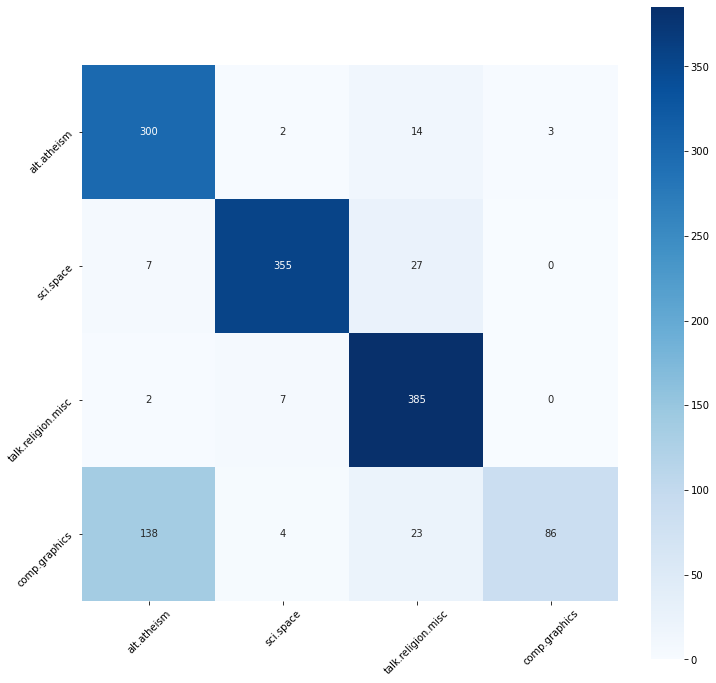

In [32]:
clfNB1.fit(X_train_tfidf, train_labels)

%time y_pred = clfNB1.predict(X_test_tfidf)
y_test = newsgroups_test.target

plt.figure(figsize=(12,12)) 

heatmap = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g')
heatmap.set_xticklabels(categories, rotation=45)
heatmap.set_yticklabels(categories, rotation=45)

In [33]:
print(classification_report(y_test, y_pred)) # Тестовая выборка

              precision    recall  f1-score   support

           0       0.67      0.94      0.78       319
           1       0.96      0.91      0.94       389
           2       0.86      0.98      0.91       394
           3       0.97      0.34      0.51       251

    accuracy                           0.83      1353
   macro avg       0.86      0.79      0.79      1353
weighted avg       0.86      0.83      0.81      1353



In [34]:
clfNB2 = MultinomialNB()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clfNB2, X_train_tfidf_ng2, train_labels, scoring='accuracy', cv=cv, n_jobs = -1)
print('mean = ', scores.mean(), ' std = ', np.std(scores))

mean =  0.9213214558042144  std =  0.016983258868796727


CPU times: user 2.49 ms, sys: 0 ns, total: 2.49 ms
Wall time: 2.5 ms


[Text(0, 0.5, 'alt.atheism'),
 Text(0, 1.5, 'sci.space'),
 Text(0, 2.5, 'talk.religion.misc'),
 Text(0, 3.5, 'comp.graphics')]

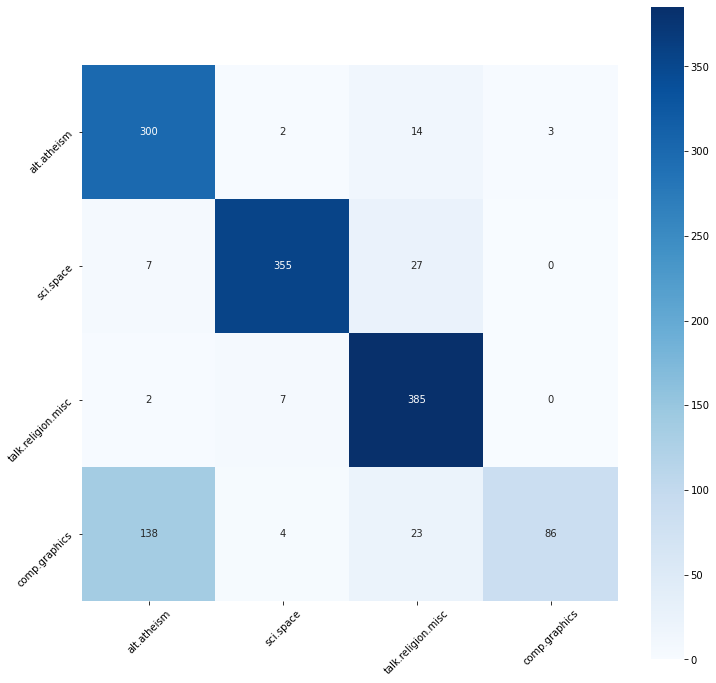

In [35]:
clfNB2.fit(X_train_tfidf, train_labels)

%time y_pred = clfNB2.predict(X_test_tfidf)
y_test = newsgroups_test.target

plt.figure(figsize=(12,12)) 

heatmap = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g')
heatmap.set_xticklabels(categories, rotation=45)
heatmap.set_yticklabels(categories, rotation=45)

In [36]:
print(classification_report(y_test, y_pred)) # Тестовая выборка

              precision    recall  f1-score   support

           0       0.67      0.94      0.78       319
           1       0.96      0.91      0.94       389
           2       0.86      0.98      0.91       394
           3       0.97      0.34      0.51       251

    accuracy                           0.83      1353
   macro avg       0.86      0.79      0.79      1353
weighted avg       0.86      0.83      0.81      1353



In [37]:
clfNB3 = MultinomialNB()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clfNB3, X_train_tfidf_ng3, train_labels, scoring='accuracy', cv=cv, n_jobs = -1)
print('mean = ', scores.mean(), ' std = ', np.std(scores))

mean =  0.9429636533084809  std =  0.008890538635688457


CPU times: user 2.66 ms, sys: 0 ns, total: 2.66 ms
Wall time: 2.67 ms


[Text(0, 0.5, 'alt.atheism'),
 Text(0, 1.5, 'sci.space'),
 Text(0, 2.5, 'talk.religion.misc'),
 Text(0, 3.5, 'comp.graphics')]

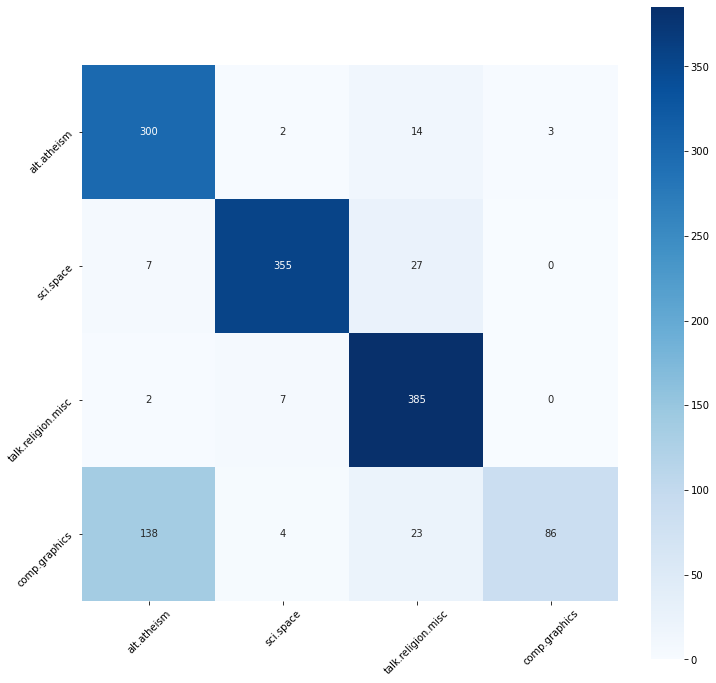

In [38]:
clfNB3.fit(X_train_tfidf, train_labels)

%time y_pred = clfNB3.predict(X_test_tfidf)
y_test = newsgroups_test.target

plt.figure(figsize=(12,12)) 

heatmap = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g')
heatmap.set_xticklabels(categories, rotation=45)
heatmap.set_yticklabels(categories, rotation=45)

In [39]:
print(classification_report(y_test, y_pred)) # Тестовая выборка

              precision    recall  f1-score   support

           0       0.67      0.94      0.78       319
           1       0.96      0.91      0.94       389
           2       0.86      0.98      0.91       394
           3       0.97      0.34      0.51       251

    accuracy                           0.83      1353
   macro avg       0.86      0.79      0.79      1353
weighted avg       0.86      0.83      0.81      1353

